In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # <-- Missing import
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import joblib

# Load engineered data from Week 4
data = pd.read_csv("engineered_data_week4.csv")
print("Data shape:", data.shape)
display(data.head(2))

Data shape: (10000, 17)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,temp_diff,power,wear_rate,machine_type,wear_bin,lag_torque,lag_rpm
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure,10.5,66382.8,0.000,M,0-50,42.8,1551.0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure,10.5,65190.4,0.003,L,0-50,42.8,1551.0


In [3]:
# Separate features and target
X = data.drop(['UDI', 'Product ID', 'Target', 'Failure Type'], axis=1)  # Keep engineered features
y = data['Target']

# One-hot encode categoricals
X = pd.get_dummies(X, columns=['Type', 'machine_type', 'wear_bin'])

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training shape:", X_train_scaled.shape, "Test shape:", X_test_scaled.shape)

Training shape: (8000, 21) Test shape: (2000, 21)


Random Forest Results:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1932
           1       0.98      0.74      0.84        68

    accuracy                           0.99      2000
   macro avg       0.99      0.87      0.92      2000
weighted avg       0.99      0.99      0.99      2000

Confusion Matrix:
 [[1931    1]
 [  18   50]]


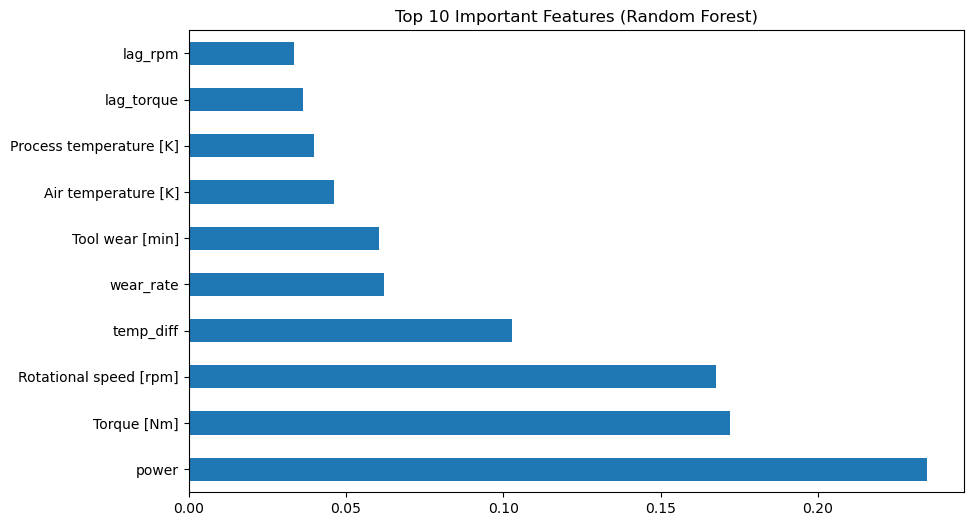

In [4]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf.predict(X_test_scaled)

# Evaluate
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# Feature importance
plt.figure(figsize=(10, 6))
pd.Series(rf.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features (Random Forest)")
plt.show()

In [7]:
from xgboost import XGBClassifier

# Initialize and train
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
xgb.fit(X_train_scaled, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test_scaled)

# Evaluate
print("\nXGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


XGBoost Results:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.93      0.76      0.84        68

    accuracy                           0.99      2000
   macro avg       0.96      0.88      0.92      2000
weighted avg       0.99      0.99      0.99      2000

Confusion Matrix:
 [[1928    4]
 [  16   52]]


In [5]:
from sklearn.neural_network import MLPClassifier

# Initialize and train
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)

# Predictions
y_pred_mlp = mlp.predict(X_test_scaled)

# Evaluate
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_mlp))


Neural Network Results:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.68      0.59      0.63        68

    accuracy                           0.98      2000
   macro avg       0.83      0.79      0.81      2000
weighted avg       0.98      0.98      0.98      2000



In [9]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1')
grid_search.fit(X_train_scaled, y_train)

# Best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_scaled)

print("\nTuned Random Forest:")
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred_best))


Tuned Random Forest:
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1932
           1       0.98      0.75      0.85        68

    accuracy                           0.99      2000
   macro avg       0.99      0.87      0.92      2000
weighted avg       0.99      0.99      0.99      2000



In [12]:
# Save artifacts
joblib.dump(best_rf, 'best_rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Verify files were saved
import os
if os.path.exists('best_rf_model.pkl') and os.path.exists('scaler.pkl'):
    print("Model and scaler saved successfully!")
else:
    print("Error: Files not saved")

Model and scaler saved successfully!
